# Projeto da III Unidade de PI Contagem de hemácias

### Alunos

- Gabriel Silva de Jesus
- Gustavo Henrique Aragão Silva

---

In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

Leitura de uma imagem para descobrir detalhes iniciais:

In [107]:
nome_image = 'BloodImage_00402.jpg'

image_color = io.imread(nome_image)


----
### Passo 1 - Extrair  os leucócitos para explorar somente hemácias

1.1 Com a sugestão do professor exploramos os canais HSV e olhamos mais especificamente para o canal H que define a cor. Assim conseguiremos remover os leucócitos. Para isso procuramos os valores maximos existentes de H numa dada imagem.


In [108]:
hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

h, s, v = cv2.split(hsv)

# Encontrar o valor máximo de HSV
max_h, max_s, max_v = np.max(h), np.max(s), np.max(v)

print("Valor máximo de H S V respectivamente:", max_h, max_s, max_v)

Valor máximo de H S V respectivamente: 179 171 246


1.2 Após encontrar os valores máximos foi feita a variacao do canal H e encontramos o intervalo de H (160 a 180) em que  leucócito está. Após encontrado  o leucocito  obtemos o conjuto complementar que é o conjunto que só existem hemácias.

```
lower = np.array([160, 0, 0])
upper = np.array([180, 161, 247])
```

veja que adicionamos 1 a mais em cada item só por segurança, mas isso não faz diferença na nossa implementação

-  1.2.0 A função abaixo cria uma mascara dado intevalos inferiores e superiores 

In [109]:
def manual_inRange(hsv, lower, upper):

    h, s, v = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    
    h_mask = np.logical_and(h >= lower[0], h <= upper[0])
    s_mask = np.logical_and(s >= lower[1], s <= upper[1])
    v_mask = np.logical_and(v >= lower[2], v <= upper[2])
    
    return (h_mask & s_mask & v_mask).astype(np.uint8) * 255

- 1.2.1 A função abaixo faz a operação de bitwise em uma imagem e uma máscara fornecida como base, se o parâmetro `negacao=True` quer dizer que estaremos aplicando a operação de not na máscara para que a imagem a ser obtida seja complementar a do intervalo h inicialmente selecionado.



In [110]:
def manual_bitwise_and(img1, mask, negacao=False):
    if  img1.shape[:2] != mask.shape[:2]:
        raise ValueError("I tamaho das imagens e da mascara deve ser iguais.")
    
    h, w, _ = img1.shape

    result_img = np.zeros((h, w, _), dtype=np.uint8)
    
    for i in range(h):
        for j in range(w):
            # pega o complementar da imagem ou não a partir do complementar da mascara
            mask_tratada = ~mask[i, j] if negacao else mask[i, j]  
            result_img[i, j] = img1[i, j] & mask_tratada # Aplica o bitwise
    
    return result_img

- 1.2.2 Por fim,  função abaixo identifica e remove os leucócitos da imagemn dada, deixando somente as hemácias que é a parte que queremos :)

In [111]:
def RemoveGlobulosBrancos(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Intervalo que se encontram os globulos brancos
    lower = np.array([160, 0, 0]) 
    upper = np.array([180, 161, 247])

    mask = manual_inRange(hsv, lower, upper) # obtém a mascara com o interva

    # Faz a limpeza de ruidos que ficam na imagem. Aplicando o fechamento e após a abertura
    b = np.ones((12,12),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, b)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, b)
   
    return manual_bitwise_and(img, mask=mask, negacao=True) 


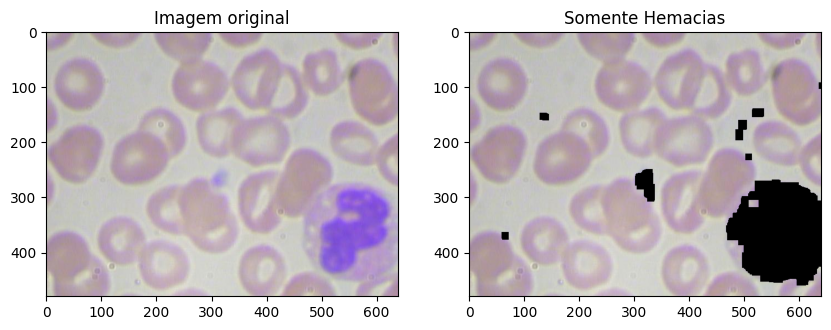

In [112]:
# testando
img_hemacias = RemoveGlobulosBrancos(image_color)

def plotarTeste(img1, msg1, img2, msg2):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
  fig.subplots_adjust(hspace= .2, wspace= .2)

  ax[0].imshow(img1)
  ax[0].set_title(msg1)

  ax[1].imshow(img2)
  ax[1].set_title(msg2)

plotarTeste(image_color, 'Imagem original', img_hemacias, 'Somente Hemacias')

----

### Passo 2 - Pré-processamento mais tratamento e limiarização das imagens.

2.1 A função abaixo faz o pré-processamento da imagem aplicando os seguintes métodos na imagem fornecida:

1. Conversão para níveis de cinza;
2. Equalização histogrâmica, que serve para melhoar o contraste das células em relação ao seu background, ajudando mais tarde na binarização da imagem;
3. Filtro gaussiano, que reduz o ruído e ajuda a detectar as bordas das células, auxiliando também no threshold.

In [113]:
def preprocessamento(hemacias):

    # Conversão para cinza
    gray_redCells = cv2.cvtColor(hemacias, cv2.COLOR_BGR2GRAY)
    
    # Equaliza a imagem
    eq_img = cv2.equalizeHist(gray_redCells)

    # Aplica o filtro gaussiano 5x5 pra remover ruidos indesejados
    k_mask_gaussian = 5
    mask_gaussian = (k_mask_gaussian, k_mask_gaussian)
    gaussian_img = cv2.GaussianBlur(eq_img, mask_gaussian, 0)

    return gray_redCells, eq_img, gaussian_img


2.2 A função meu_adaptiveThreshold implementa um algoritmo de limiarização adaptativa em imagens em tons de cinza. Ela calcula limiares localmente com base na média ou no desvio padrão dos valores de intensidade em regiões específicas da imagem. Dependendo do método escolhido, o limiar é ajustado pela média ou pela média operada com o desvio padrão. 

No nosso projeto testamos tanto a média quanto o desvio padrão e com base  nos testes selecionamos a opção da média pois foi ela que nos deu a melhor acurácia.

In [114]:
def meu_adaptiveThreshold(img, max_level, metodo, type_threshold, block_size, C):
    
    tamanho_borda = block_size // 2

    # Adiciona borda à imagem de entrada
    borda_img = np.pad(img, tamanho_borda, mode='constant')

    img_saida = np.zeros_like(img)

    j, i = img.shape
    for y in range(tamanho_borda, j + tamanho_borda):
        for x in range(tamanho_borda, i + tamanho_borda):
            regiao_sele = borda_img[y - tamanho_borda:y + tamanho_borda + 1, x - tamanho_borda:x + tamanho_borda + 1]
            
            if metodo == 0:
                threshold_value = np.mean(regiao_sele) - C # Aplica o threshold da media
            else:
                 # aplica o threshold com desvio padrao
                threshold_value = np.mean(regiao_sele) - C * np.std(regiao_sele) / block_size
            
            # Essa região aplica a binarização se satisfeita as condições da região
            if type_threshold == 0:
                img_saida[y - tamanho_borda, x - tamanho_borda] = max_level if img[y - tamanho_borda, x - tamanho_borda] > threshold_value else 0
            
            else:
                img_saida[y - tamanho_borda, x - tamanho_borda] = 0 if img[y - tamanho_borda, x - tamanho_borda] > threshold_value else max_level
    
    return img_saida



2.3 A função abaixo recebe uma imagem já pré-processada e aplica o treshold adaptativo, após disso aplica uma erosão fazendo a limpeza de ruídos e por fim me dá o inverso da imagem.


Essa função vai retornar para a gente a imagem limiarizada fazendo com que consigamos reconhecer circulos de determinado raio e perímetro. A forma como foi padronizada para se adptar ao nosso projeto será explicada no passo 3.

In [115]:
def binariza_imagem(img_processada):
    '''
    Binariza a imagem  de forma adaptativa com o uso do método obtivemos os 
    melhores resultados para as imagens selecionadas ajustamos para 
    '''

    img_binary = meu_adaptiveThreshold(img_processada, 255, 0, 1, 15, 7)

    # Aplicacao da erosao para fazer uma limpeza nos ruídos
    k = 5
    i = 5
    kernel = np.ones((k,k),np.uint8)
    img_erodida = cv2.erode(img_binary, kernel, i)

    inverso = 255-img_erodida

    return img_binary, img_erodida, inverso

2.4 Abaixo veja o teste de todos os passos desta seção.

Text(0.5, 1.0, 'Imagem Erodida')

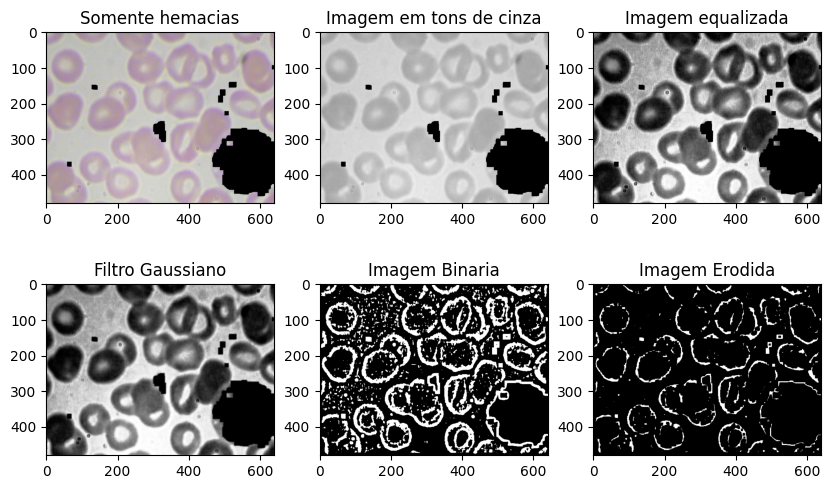

In [122]:
# Testando 

img_gray, img_eq, img_gaussian = preprocessamento(img_hemacias)
img_binary, img_erode, img_inverse = binariza_imagem(img_gaussian)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
fig.subplots_adjust(hspace= .2, wspace= .2)


ax[0][0].imshow(img_hemacias)
ax[0][0].set_title('Somente hemacias')

ax[0][1].imshow(img_gray, cmap='gray')
ax[0][1].set_title('Imagem em tons de cinza')

ax[0][2].imshow(img_eq, cmap='gray')
ax[0][2].set_title('Imagem equalizada')

ax[1][0].imshow(img_gaussian, cmap='gray')
ax[1][0].set_title('Filtro Gaussiano')

ax[1][1].imshow(img_binary, cmap='gray')
ax[1][1].set_title('Imagem Binaria')

ax[1][2].imshow(img_erode, cmap='gray')
ax[1][2].set_title('Imagem Erodida')



### Passo 3 - Métologia da detecção de circulos.


3.1 A função abaixo aplica a transformada circular de hough na imagem limiarizada, e a partir da grade de acumuladores gerada desenha círculos e seus respectivos pontos de centróides em cima das hemácias na imagem de entrada fazendo também a contagens das hemácias.

Com base em vários testes manuais aplicamos a HoughCircles com esses parâmetros e será explicado no passo 3.2

In [ ]:
def identifica_hemacias(img, binary_image):

    celulas = img.copy()

    circles = cv2.HoughCircles(binary_image,cv2.HOUGH_GRADIENT,1,68,
                             param1=33,param2=11,minRadius=30,maxRadius=58)
    
    hemacias_count = 0

    circles = np.uint32(np.around(circles))
    for i in circles[0,:]:
        cv2.circle(celulas,(i[0],i[1]),i[2],(0,255,0),2)
        cv2.circle(celulas,(i[0],i[1]),2,(0,0,255),3)

        hemacias_count +=1

    
    return celulas, hemacias_count

3.2 Como você pode ver a transformada circular de hough foi aplicada dessa forma

```
circles = cv2.HoughCircles(binary_image,cv2.HOUGH_GRADIENT,1,68,
                             param1=33,param2=11,minRadius=30,maxRadius=58)
```

Uma breve explicação do porquê que chegamos a esses parametros

1. **O primeiro parâmetro** é a imagem binarizada
2. **O segundo parâmetro** indica que é usada a técnica do gradiente para detectar bordas na imagem. Ela explora as mudanças bruscaa de intensidade nos pixels da imagem para identificar as regiões onde ocorrem essas mudanças que frequentemente correspondem a bordas entre objetos na regiao. 
3. **O terceiro parametro**  1 indica que a resolução da imagem de entrada é mantida na aplicação da transformada de Hough. E claro que selecionamos 1
4. **quarto parâmetro** é a distância mínima entre os centros dos círculos detectados e se a distancia entre os centros for menor que que esse valor apenas o de maior confiança que sera adicionado, fizemos testes de 50 a 70 e vimos que o melhor valor para o nosso caso está entre 65 e 70 optamos por deixar em 68.
5. **O quinto parametro** param1=50 ele é usado para definir a sensibilidade do detector de bordas interno do HOUGH_GRADIENT. Valores menores de param1 resultarão em mais círculos sendo detectados (possivelmente com mais falsos positivos). testamos de 20 a 70 e 33 foi um bom numero para nós.
6. **O sexto parâmetro** para2=11 e é usado para definir o limite mínimp para a detecção de bordas. Valores menores de param2 resultarão em mais círculos sendo detectados, mas também em mais falsos positivos. Geralmente o param2 é igual a param3/3 e foi o que a gente fez aqui. Testamos ele de 5 a 33 e esse foi o melhor valor.
7. **O sétimo parâmetro**  minRadius=30 Este é o raio mínimo do círculo a ser detectado. Qualquer círculo com um raio menor do que este valor não será detectado. Testamos minRadius de 20 a 40, e 30 foi o melhor equilibrio para identificar com poucos falsos positivos, falsos negativos e uma boa quantidade de Verdadeiros positivos . 
8. **Oitavo parâmetro**  maxRadius=58 quer dizer que qualquer círculo com um raio maior do que este valor não será detectado .Testamos  valores entre 45 e 70 e 68 nos trouxe resultrados  bons com uma quantidade baixa de falsos positivose falsos negativos com uma boa quantidade de Verdadeiros positivos. 





3.3 Metodologia usada para o projeto.

3.1.1. Foram selecionadas cinco imagens que tivessem disposição de elementos e cores diferentes umas das outras. Imagens abaixo


In [ ]:
img1 = io.imread('BloodImage_00339.jpg')
img2 = io.imread('BloodImage_00343.jpg')
img3 = io.imread('BloodImage_00351.jpg')
img4 = io.imread('BloodImage_00364.jpg')
img5 = io.imread('BloodImage_00396.jpg')
img6 = io.imread('BloodImage_00402.jpg')